## Urban Indicators: An Analytics Tool
##### Author: Jerome Maiquez

The aim of this project was to develop an analytics tool focusing
on urban form. The tool currently only supports two indicators: POI density (currently only skyscrapers) and betweenness centrality of street intersections. The tool is tested for the area surrounding the three biggest central business districts (CBDs) in Metro Manila: Makati, Bonifacio Global City (BGC), and Ortigas Center.

Much of the functionality in this tool is defined in functions in a separate script file. Future improvements (which I can't promise will come) include the ability to select from a pre-defined, bigger set of POIs to map and analyze, cleaned-up code (by wrapping them in script functions), and better documentation overall.

This project was developed as the final assignment for the [AutoGIS](https://autogis-site.readthedocs.io/en/latest/final-assignment/final-assignment.html#urban-indicators) course provided for free by the University of Helsinki.

Major functionalities:
- fetch & create maps of street networks and POIs within a buffer of specified radius around a geocoded place name
- create heatmaps of relevant point geometries (e.g. POIs, street intersections) within this same buffer
- create plots with a very specific style (circular map, text in the bottom left, line width proportional to lane number, etc.)

Supported urban indicators:
- street network (geometry)
- street intersection (heatmap)
- skyscraper POI density (heatmap)
- intersection betweenness centrality (heatmap)

Potential urban indicators to add:
- [education facility](https://data.humdata.org/dataset/hotosm_phl_education_facilities) POI density (heatmap)
- [health facility](https://data.humdata.org/dataset/hotosm_phl_health_facilities) POI density (heatmap)
- [financial services](https://data.humdata.org/dataset/hotosm_phl_financial_services) POI density (heatmap)
- commercial amenities POI density (heatmap)
- public institutions POI density (heatmap)
- isochrone from central point in map (geometry?)

#### Part 1: Plotting a Street Network (with Style)

First, we plot a street network around a specified place, with style.

Step 1: Import packages

Here are the Python packages used for this project. A lot of the aliases are greyed out because much of the tool's functionality are defined in functions in a separate script file, each of which imports the libraries it needs itself. 

(Do let me know if there are better practices regarding this!)

In [1]:
import osmnx as ox
import geopandas as gpd
import contextily as cx
import shapely as shp
import matplotlib.pyplot as plt
import numpy as np
from scipy import ndimage
import networkx as nx

Step 2: Generate buffer around location of interest

Here we see the first of the custom functions defined for this tool: `get_buffer_from_place()`. It takes in a Nominatim-valid place name (`str`) and a buffer radius (`int`) and returns a circle with the specified radius around the geocoded place name.

For this example, we set the query as `"Barangka Ibaba"`, a barangay in Mandaluyong, Metro Manila, because it is exactly in the middle of the three CBDs that I wanted to feature in the map. The `buffer_dist` is set to `4_000`, or 4 kilometers, to ensure all CBDs are included.

In [2]:
# Set name for Nominatim query
query = "Barangka Ibaba"
buffer_dist = 4_000

# Get buffer with aforementioned parameters using custom function
from urban_indicators_scripts import get_buffer_from_place

buffer = get_buffer_from_place(query, buffer_dist)

To check if the buffer is at the desired location and size, we can plot it with a basemap using the `contextily` package.

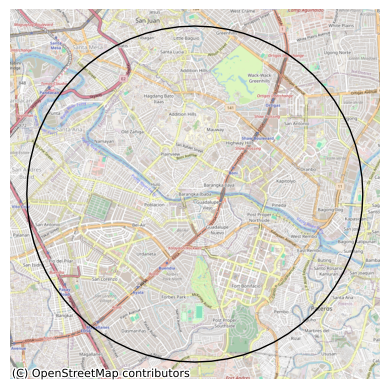

In [3]:
# Check if buffer location is correct
ax = buffer.to_crs("EPSG:3857").plot(
    facecolor="none"
)
cx.add_basemap(ax=ax, source=cx.providers.OpenStreetMap.Mapnik)
ax.set_axis_off()

Step 3: Extract street network within buffer then pre-process

We then extract the street network within our defined buffer using `osmnx`'s `graph_from_polygon()` function, which returns a `MultiDiGraph` object representing a street network. As a graph, it allows all sorts of interesting network analyses, some of which we will see later. 

But for now, we immediately convert it to vector geometry via the `graph_to_gdfs()` function. The intersections (graph nodes) and streets (graph edges) are stored in separate GeoDataFrames.

In [4]:
# Get road network within buffer
graph = ox.graph_from_polygon(
    buffer.geometry[0],
    network_type="all_private",
    retain_all=True,
    simplify=True
)

# Convert intersections and streets to geodataframe
intersections, streets = ox.graph_to_gdfs(graph)

We then pre-process the `streets` GDF, first by reprojecting it (alongside `intersections`) to Web / Pseudo Mercator `"EPSG:3857"`, and then by parsing the `lanes` column using the `parse_street_lanes()` custom function I made.

Why does it need parsing? In OSM, attributes such as `lanes` can have either single values (of type e.g. `int`), or it can have a list whose items are those values (e.g. `lanes = [2, 3, 5]`). Moreover, a lot of the street records have `NaNs` in many columns, including `lanes`.

As such, we must process the `lanes` column by 1) setting `NaN`s to a value of 1, 2) replacing list values with its maximum item, and 3) converting the `lanes` data type to `int` to avoid any `float` shenanigans.

In [5]:
# Reproject both GDFs to pseudo-mercator
streets = streets.to_crs("EPSG:3857")
intersections = intersections.to_crs("EPSG:3857")

In [6]:
# Parse `lanes` column in streets GDF using custom function
from urban_indicators_scripts import parse_street_lanes

streets = parse_street_lanes(streets)
streets.lanes.unique()

array([2, 4, 1, 3, 5, 6])

In [7]:
streets.head()

osmid  oneway  lanes  ref  \
u        v          key                                                         
12067613 962953430  0    [29256184, 188165094, 188165111]    True      2    1   
         12067619   0                           264965502    True      4    1   
12067619 6970838871 0                           927257054    True      1  NaN   
         8459730704 0                           671955931    True      2    1   
12067627 8242414108 0                            22598208   False      2  NaN   

                                          name   highway maxspeed reversed  \
u        v          key                                                      
12067613 962953430  0      [EDSA, Shaw Tunnel]     trunk       60    False   
         12067619   0                     EDSA     trunk       60    False   
12067619 6970838871 0    Starmall Service Road   service      NaN    False   
         8459730704 0                     EDSA     trunk       60    False   
12067627 8242414108 0               Apo Street  tertiary      NaN    False   

                          length tunnel  \
u        v          key                   
12067613 962953430  0    860.735    yes   
         12067619   0    186.206    NaN   
12067619 6970838871 0      5.516    NaN   
         8459730704 0    194.543    NaN   
12067627 8242414108 0      6.785    NaN   

                                                                  geometry  \
u        v          key                                                      
12067613 962953430  0    LINESTRING (13475833.935 1641363.380, 13475829...   
         12067619   0    LINESTRING (13475833.935 1641363.380, 13475821...   
12067619 6970838871 0    LINESTRING (13475743.466 1641194.729, 13475738...   
         8459730704 0    LINESTRING (13475743.466 1641194.729, 13475668...   
12067627 8242414108 0    LINESTRING (13474860.424 1639875.264, 13474853...   

                        access width bridge service junction  
u        v          key                                       
12067613 962953430  0      NaN   NaN    NaN     NaN      NaN  
         12067619   0      NaN   NaN    NaN     NaN      NaN  
12067619 6970838871 0      NaN   NaN    NaN     NaN      NaN  
         8459730704 0      NaN   NaN    NaN     NaN      NaN  
12067627 8242414108 0      NaN   NaN    NaN     NaN      NaN

Step 4: Plotting the street network and intersection heatmap

Here we plot the street network in a very specific style via the custom `plot_streets()` function. It takes in two main parameters: `streets_gdf` (the street network GDF to be plotted) and `ring_gdf` (the buffer GDF).

It can also take in a specified `title` and `subtitle`. If not supplied, these will simply be the geocoded placename (minus everything after the first comma) and `"Road network within X km buffer"`, respectively.

As for the plot style itself, a `width_factor` can also be specified, which will be used to set the line width based on the `lanes` value of each street. Lastly, `color_scheme` takes in a `matplotlib`-valid color, whose first and last colors will be used as colors for the background and the plot elements.

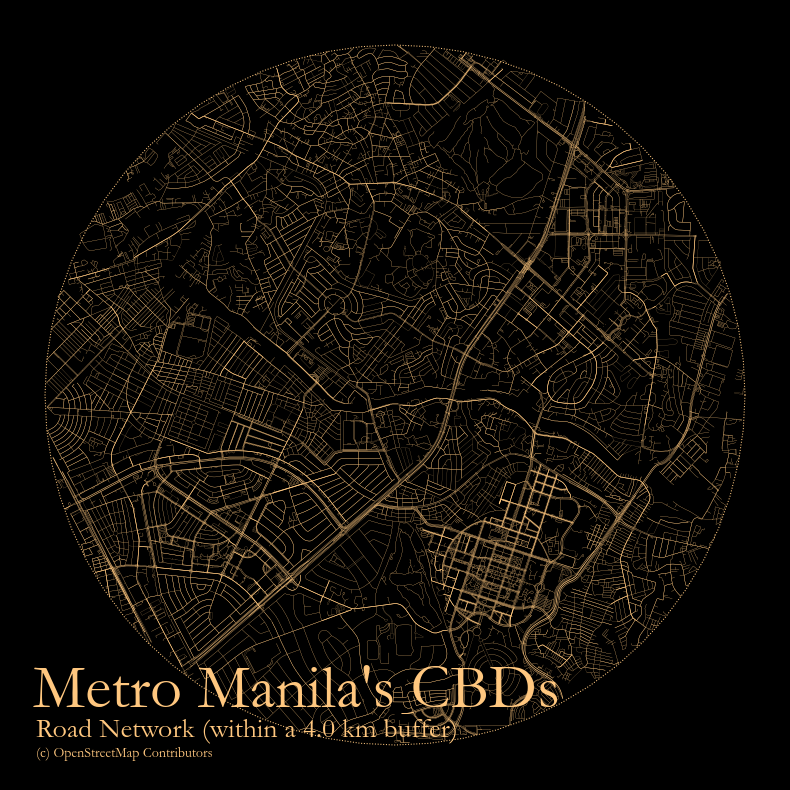

In [8]:
# Plot street network using custom functions (defined in scripts file)
from urban_indicators_scripts import plot_streets, plot_heatmap

fig, ax, ring_bounds = plot_streets(
    streets,
    buffer,
    title="Metro Manila's CBDs",
    # subtitle="Road network",
    width_factor=0.1,
    color_scheme="copper"
)

# Plot a heatmap of the street intersections...
# ...weighted by the no. of streets per intersection
# plot_heatmap(
#     intersections,
#     "street_count",
#     bins=500,
#     ax=ax,
#     alpha=0.7,
#     color_scheme="BuPu_r",
#     bounds=ring_bounds
# )

#### Part B: Generating a heatmap for other POIs

Next, we generate a heatmap of a given kind of POI, and overlay it on top of our street network. 

Step 1: Extract POIs within buffer

The tool currently only supports skyscrapers as its POI type, which is defined as buildings with at least 20 floors. In OSM, this is stored in the `building:levels` attribute. 

OSMnx queries take in a `dict`, with the OSM tags as the keys and the desired values as, well, the values. For us to get buildings with a minimum number of floors, we generate a list of numerical `str`s between 20 and 100 via list comprehension. 

Why `str` and not `int`? I've had issues before with letting it stay as `int`, which may be because the `building:levels` column of the resulting GDF from the OSMnx query is of type `object`.

In [9]:
# Extract all shops within the buffer
pois = ox.features_from_polygon(
    buffer.geometry[0],
    {
        # "shop": True,
        # "amenity": ["fast_food", "restaurant", "cafe"]
        "building:levels": [str(i) for i in range(20,100)],
    }
)

# Examine number of rows and columns
pois.shape

(736, 79)

Step 2: Clean up POI data

Next, we clean up the POI GDF. First, we drop all unnecessary columns (defined as those where most of the values are `NaNs`) via the custom `drop_nan_cols()` function. Aside from the GDF to be cleaned, it also takes in an `na_cutoff_percent` parameter which, as the name suggests, is the percentage of records in a column that are 'NaNs` above which it will be dropped.

Next, we reset the column indices to flatten MultiIndex column, and then we assign a value of 1.0 to a new `weights` column. This will serve as the weights for when we plot the heatmap. 

This isn't as relevant for skyscraper POIs, however, as we will instead be using floor numbers x floor area as our heatmap weight, as we will see later.

In [10]:
# Import drop_nan_cols function we created
from urban_indicators_scripts import drop_nan_cols, filter_elem_type

# Apply imported function
# Parameters: gdf, max % of rows that are NaNs
pois = drop_nan_cols(pois, 0.75)

In [11]:
# Examine # of rows & cols after pre-processing
pois.shape

(736, 8)

In [12]:
# Flatten column indices
# (this should be in the function)
pois = pois.reset_index()

pois.head()

,element_type,osmid,geometry,addr:city,name,nodes,building,building:levels,height,building:part
0,way,22788808,"POLYGON ((121.02140 14.55751, 121.02152 14.557...",Makati,Philamlife Tower,"[244891956, 244891957, 244891958, 244891959, 2...",commercial,48,200,NaN
1,way,24547892,"POLYGON ((121.03491 14.56385, 121.03491 14.563...",NaN,Hidalgo Place,"[266904913, 5209772931, 5209772930, 266904914,...",residential,24,87.6,NaN
2,way,24547895,"POLYGON ((121.03508 14.56457, 121.03504 14.564...",NaN,Rizal Tower,"[266905127, 2312911335, 2312911334, 2312911330...",apartments,47,161,NaN
3,way,24547947,"POLYGON ((121.03508 14.56529, 121.03488 14.565...",NaN,Luna Gardens,"[266905163, 266905164, 266905165, 266905166, 2...",apartments,39,134.9,NaN
4,way,24547950,"POLYGON ((121.03551 14.56572, 121.03551 14.565...",NaN,Amorsolo East,"[266905215, 266905216, 266905217, 266905218, 2...",residential,30,107,NaN


In [13]:
# Assign weight to all POIs (for heatmap)
# relevant for other POI types (e.g. shops)
pois["weight"] = 1.0

We then reproject the POIs GDF to Web Mercator once again, and then we set the centroids of the POI polygons as their new active geometries to convert them to points.

In [14]:
# Reproject to Pseudo-Mercator
pois = pois.to_crs("EPSG:3857")

In [15]:
# Set feature geometries as their centroids
# (this should be in the function)
pois["geometry"] = pois["geometry"].centroid
pois.shape

(736, 11)

Here, we perform the functionality of the `parse_street_lanes()` function, but for the `building:levels` column. Perhaps a future improvement could be reworking that function to work for any specified column, not just for `lanes`.

In [16]:
# If value in `building:levels` is a list, get max value
pois["building:levels"] = pois["building:levels"].apply(
    lambda x: max(x) if isinstance(x, list) == True else x
)

# Convert `building:levels` data type to int
pois["building:levels"] = pois["building:levels"].astype(int)

Step 3: Plot POI density heatmap

Here, we finally plot the POI density heatmap on top of the street network using the `plot_heatmap()` function. This function takes in the GDF of the POIs in question (`gdf`), as well as the GDF column to be used as weights (`weights`). 

As for plotting it, the function also takes in `bounds` (the total bounds of the buffer used), `bins` (the number of pixels on both dimensions of the heatmap), `smoothing` (the smoothing factor for the Gaussian filter), `alpha` (the opacity of the heatmap), and finally, `color_scheme` (the color map used for the heatmap).

How does the function work? The heatmap is essentially a `numpy` 2D histogram of the points' x- and y-coordinates with the supplied weight. This 2D histogram is converted to its natural log (with negative infinity pixels re-valued to 0), and filtered with a Gaussian filter to smooth out the color gradients.

This logarithmic, Gaussian 2D histogram is then plotted via `pyplot`'s `Axes.imshow`, but all pixels where the value is below 0.01 is masked.

d:\WORK\ONLINE COURSES\AUTOGIS\final-assignment-jeromemaiquez\urban_indicators_scripts.py:406: RuntimeWarning: divide by zero encountered in log2
  logheatmap = np.log2(heatmap)
d:\WORK\ONLINE COURSES\AUTOGIS\final-assignment-jeromemaiquez\urban_indicators_scripts.py:410: DeprecationWarning: Please use `gaussian_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  logheatmap = ndimage.filters.gaussian_filter(


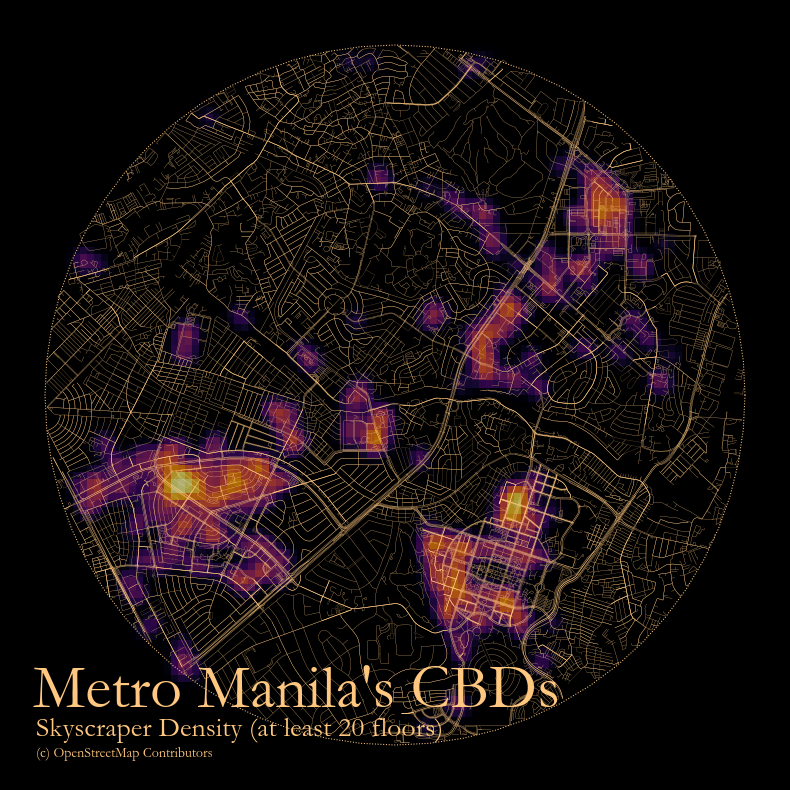

In [17]:
# Return fig, ax, and bounds from plot_streets()...
# ...for use in plot_heatmap()
fig, ax, ring_bounds = plot_streets(
    streets,
    buffer,
    title="Metro Manila's CBDs",
    subtitle="Skyscraper Density (at least 20 floors)",
    width_factor=0.1,
    color_scheme="copper"
)

plot_heatmap(
    pois,
    "building:levels",
    bins=100,
    ax=ax,
    alpha=0.7,
    color_scheme="inferno",
    bounds=ring_bounds
)

The resulting plot shows a heatmap of skyscraper distribution in Metro Manila's three CBDs: Makati (in the southwest), BGC (in the southeast), and Ortigas (in the northeast). 

These three localities collectively comprise the economic center of gravity not only of the Manila megacity, but of the Philippines as a whole. What's even more interesting is the polycentricity of corporate agglomeration. Why three separate clusters?

#### Part C: Visualizing betweenness centrality of street intersections

Finally, we visualize the most important intersections in our street network. We do this by calculating betweenness centrality, which we will explain below.

Step 1: Calculate betweenness centrality per node

The Python package `networkx` has a function called `betweenness_centrality`, which computes this metric for all the nodes in the network. But what the heck is betweenness centrality?

In graph (or network) theory, a node's betweenness is the fraction of all shortest paths in the network that pass through that node. The higher the betweenness, the more paths pass through this node. It's a rough measure of its importance in the network.

However, this is a very costly calculation to perform. To do it, `networkx` must first find the shortest path between all possible origin-destination node pairs in the network. This can easily balloon as the AOI buffer expands. As such, we define a `k` number of randomly sampled nodes to use for the calculation.

As we can see, our `k` is only around 3% of the total number of intersections in the buffer area. Still, it provides a good rough estimate of the spatial distribution of the betweenness measures for the nodes in the whole street network.

In [18]:
len(intersections)

16383

In [19]:
# Can't run for very big networks, even with k ~= 1% of total no. of nodes
bc = nx.betweenness_centrality(graph, weight="street_count", k=500)

Step 2: Join betweenness values to each node via osmid

After computing the betweenness centrality for each node, we join them to the nodes themselves via `networkx`'s `set_node_attributes()` function.

In [20]:
nx.set_node_attributes(graph, bc, "bc")

Step 3: Convert graph to GDFS, then preprocess

After having set the betweenness centrality as an additional attributes to the nodes, we once again convert both streets and intersections to GDF and perform the necessary pre-processing. In particular, we multiply the `bc` column by `1_000` because, as you'll recall, the `plot_heatmap()` function takes the natural log of the heatmap pixels' values. We multiply by `1_000` to ensure all values are above 1.0.

In [21]:
intersections, streets = ox.graph_to_gdfs(graph)

In [22]:
streets = streets.to_crs("EPSG:3857")
intersections = intersections.to_crs("EPSG:3857")

In [23]:
# Parse `lanes` column in streets GDF using custom function
from urban_indicators_scripts import parse_street_lanes

streets = parse_street_lanes(streets)
streets.lanes.unique()

array([2, 4, 1, 3, 5, 6])

In [24]:
# Multiply by 1,000 (since function calculates log of heatmap)
intersections["bc_1k"] = intersections["bc"] * 1_000

Step 4: Plot betweenness centrality!

Now we plot the betweenness centrality heatmap, largely with the same parameters as the skyscraper POI heatmap! As we can see, the brightest spots in the heatmap roughly correspond to the most important intersections for each of the three CBDs. 

However, bright spots can also be found in the San Juan-Mandaluyong area, away from the CBDs. This area roughly corresponds to the geographic center of the entire Metro Manila, and so it makes sense that many paths go through them.

This indicator is more interesting when plotting areas where road connectivity is poor, because it clearly shows the chokepoints in the street network. To show that, I'd try a query of `"Masinag, Antipolo"` and a buffer radius of `2_000`.

d:\WORK\ONLINE COURSES\AUTOGIS\final-assignment-jeromemaiquez\urban_indicators_scripts.py:406: RuntimeWarning: divide by zero encountered in log2
  logheatmap = np.log2(heatmap)
d:\WORK\ONLINE COURSES\AUTOGIS\final-assignment-jeromemaiquez\urban_indicators_scripts.py:410: DeprecationWarning: Please use `gaussian_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  logheatmap = ndimage.filters.gaussian_filter(


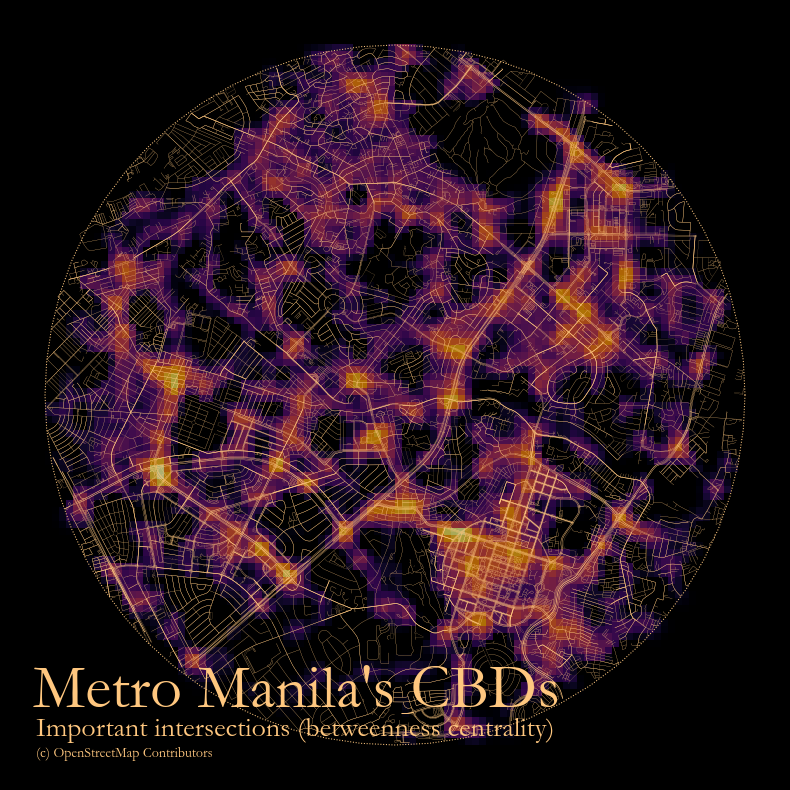

In [25]:
# Plot street network
from urban_indicators_scripts import plot_streets, plot_heatmap

fig, ax, ring_bounds = plot_streets(
    streets,
    buffer,
    title="Metro Manila's CBDs",
    subtitle="Important intersections (betweenness centrality)",
    width_factor=0.1,
    color_scheme="copper"
)

# Plot heatmap of betweenness centrality
plot_heatmap(
    intersections,
    "bc_1k",
    ax=ax,
    alpha=0.7,
    color_scheme="inferno",
    bounds=ring_bounds
)

There you go! This was a demonstration of the (very rough) urban analytics tool I created for the University of Helsinki's AutoGIS course, which is available online. It took me ages to finish this thing, partly because it took me long to decide what indicators I wanted to show, and partly because I was so busy with my new job.

Truthfully, calculating the indicators was the easy part. The hardest aspect of this project was getting `matplotlib` to do what I wanted it to do, especially when it comes to positioning text and working with 2D histograms in pyplot. I am very open to suggestions for other (geo)visualization packages!

Finally, I will once again list potential urban indicators to add:
- [education facility](https://data.humdata.org/dataset/hotosm_phl_education_facilities) POI density (heatmap)
- [health facility](https://data.humdata.org/dataset/hotosm_phl_health_facilities) POI density (heatmap)
- [financial services](https://data.humdata.org/dataset/hotosm_phl_financial_services) POI density (heatmap)
- commercial amenities POI density (heatmap)
- public institutions POI density (heatmap)
- isochrone from central point in map (geometry?)

Thank you, and I hope you enjoyed!